In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ExponentialLR

# Dataset retrieved from
https://www.kaggle.com/datasets/shayanfazeli/heartbeat

In [2]:
# Dataset retrieved from https://www.kaggle.com/datasets/shayanfazeli/heartbeat
# 2 datasets given, here we use the bigger dataset

# train data
train = pd.read_csv('mitbih_train.csv', header=None)
train.sample(frac=1).reset_index(drop=True)
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
train_y = train_y.astype('int')
train_X = train_X.astype('float')

# test data
test = pd.read_csv('mitbih_test.csv', header=None)
test.sample(frac=1).reset_index(drop=True)
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
test_y = test_y.astype('int')
test_X = test_X.astype('float')

# to numpy
train_X = train_X.to_numpy().reshape(-1, 1, 187) # add channel dimension
train_y = train_y.to_numpy().reshape(-1, 1)
test_X = test_X.to_numpy().reshape(-1, 1, 187)
test_y = test_y.to_numpy().reshape(-1, 1)

# normalisation
train_X = (train_X - train_X.mean()) / train_X.std()
test_X = (test_X - test_X.mean()) / test_X.std()

# Visualise some ECGs

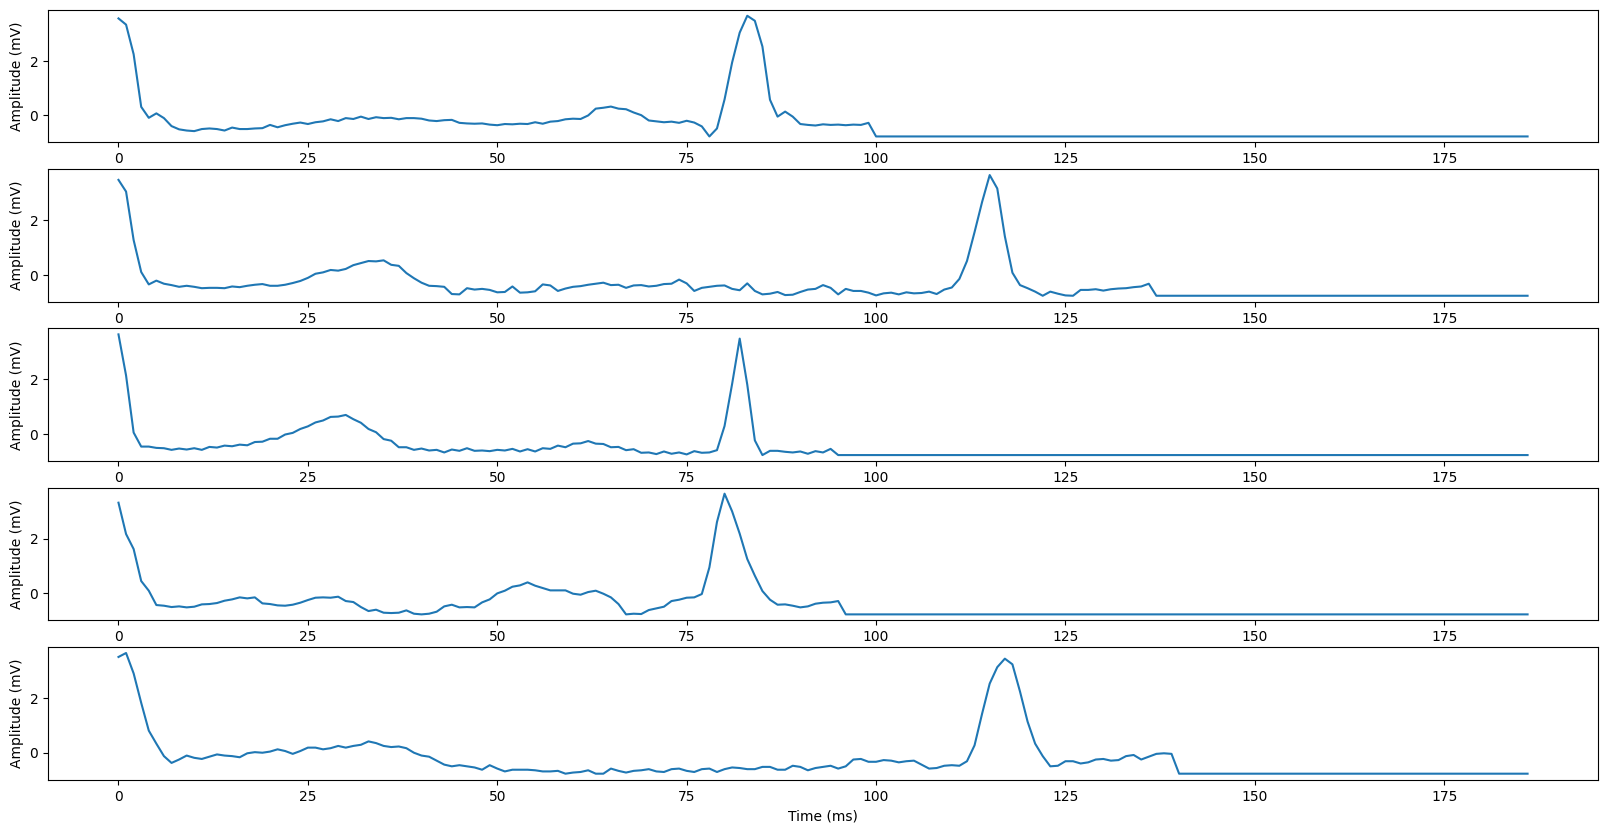

In [3]:
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
for i in range(5):
    ax[i].plot(train_X[i, 0, :])
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

In [4]:
# convert to tensor dataset
train_set = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).long())
val_set = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).long())

# sample weight
class_sample_count = np.unique(train_y, return_counts=True)[1].astype('float')
class_sample_count /= np.sum(class_sample_count) # normalise
weight = 1 / class_sample_count
weight /= weight.sum() # normalise
data_weight = np.zeros(train_y.shape[0])
for i in range(train_y.shape[0]):
    data_weight[i] = weight[train_y[i]]

# Define the CNN

In [5]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = nn.Sequential(nn.Conv1d(1, 32, kernel_size=5, stride=2),
                                    nn.BatchNorm1d(32),
                                    nn.ReLU(),
                                    nn.Conv1d(32, 32, kernel_size=1),
                                    nn.ReLU()
        )
        self.block2 = nn.Sequential(nn.Conv1d(32, 64, kernel_size=3, stride=2),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU(),
                                    nn.Conv1d(64, 64, kernel_size=1),
                                    nn.ReLU()
        )
        self.block3 = nn.Sequential(nn.Conv1d(64, 5, kernel_size=2, stride=1),
                                    nn.BatchNorm1d(5),
                                    nn.ReLU(),
                                    nn.Conv1d(5, 5, kernel_size=1),
                                    nn.ReLU()
        )
        self.adapt = nn.AdaptiveAvgPool1d(1)
        self.mp = nn.MaxPool1d(3, stride=2)
        self.dropout = nn.Dropout(0.1)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.block1(x)
        x = self.mp(x)
        x = self.dropout(x)
        x = self.block2(x)
        x = self.mp(x)
        x = self.dropout(x)
        x = self.block3(x)
        x = self.adapt(x)
        x = self.flat(x)
        return x

# Set hyperparameters and define model

In [ ]:
# hyperparameters
batch, num_epochs = 32, 50
lr, momentum, weight_decay, gamma = 0.1, 0.8, 1e-3, 0.95

# have GPU?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Load data and start training

In [6]:
# Data loaders
train_loader = DataLoader(train_set, batch_size=batch, sampler=WeightedRandomSampler(weights=data_weight, num_samples= len(train_y)))
val_loader = DataLoader(val_set, batch_size=batch, shuffle=True)

# store performance
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

# Train the neural network
for epoch in range(num_epochs):
    # Train for one epoch
    model.train()
    train_loss, train_correct = 0, 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred.squeeze(), y.squeeze())
        # L2 regularization
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)
        loss += weight_decay * l2_reg
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        train_correct += (torch.argmax(y_pred, dim=1) == y.squeeze()).sum().item()
    scheduler.step()

    # Evaluate the model on the validation set
    model.eval()
    val_loss, val_correct = 0, 0
    val_targets, val_pred = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred.squeeze(), y.squeeze())
            val_loss += loss.item() * X.size(0)
            val_correct += (torch.argmax(y_pred, dim=1) == y.squeeze()).sum().item()

    # Print the loss and accuracy for the training and validation sets
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    print("Epoch {}: Train Loss {:.4f}, Train Acc {:.2f}%, Val Loss {:.4f}, Val Acc {:.2f}%, lr {:.3f}".format(
        epoch+1, train_loss, 100*train_acc, val_loss, 100*val_acc, optimizer.param_groups[0]['lr']))

Epoch 1: Train Loss 0.6206, Train Acc 80.13%, Val Loss 0.6938, Val Acc 73.89%, lr 0.095
Epoch 2: Train Loss 0.4753, Train Acc 86.31%, Val Loss 0.7180, Val Acc 71.97%, lr 0.090
Epoch 3: Train Loss 0.4433, Train Acc 87.69%, Val Loss 0.3321, Val Acc 89.00%, lr 0.086
Epoch 4: Train Loss 0.4215, Train Acc 88.75%, Val Loss 0.2778, Val Acc 91.15%, lr 0.081
Epoch 5: Train Loss 0.4038, Train Acc 89.27%, Val Loss 0.2436, Val Acc 92.46%, lr 0.077
Epoch 6: Train Loss 0.3841, Train Acc 90.24%, Val Loss 0.3084, Val Acc 89.21%, lr 0.074
Epoch 7: Train Loss 0.3831, Train Acc 90.32%, Val Loss 0.3259, Val Acc 88.32%, lr 0.070
Epoch 8: Train Loss 0.3709, Train Acc 90.91%, Val Loss 0.3587, Val Acc 88.44%, lr 0.066
Epoch 9: Train Loss 0.3636, Train Acc 91.26%, Val Loss 0.2169, Val Acc 93.00%, lr 0.063
Epoch 10: Train Loss 0.3579, Train Acc 91.47%, Val Loss 0.1668, Val Acc 94.68%, lr 0.060
Epoch 11: Train Loss 0.3566, Train Acc 91.66%, Val Loss 0.2965, Val Acc 89.75%, lr 0.057
Epoch 12: Train Loss 0.3489, T

In [7]:
train_acc_list = np.array(train_acc_list)
train_loss_list = np.array(train_loss_list)
val_acc_list = np.array(val_acc_list)
val_loss_list = np.array(val_loss_list)
t = []
for i in range(num_epochs):
    t.append(i + 1)

# Plot the training and validation accuracies

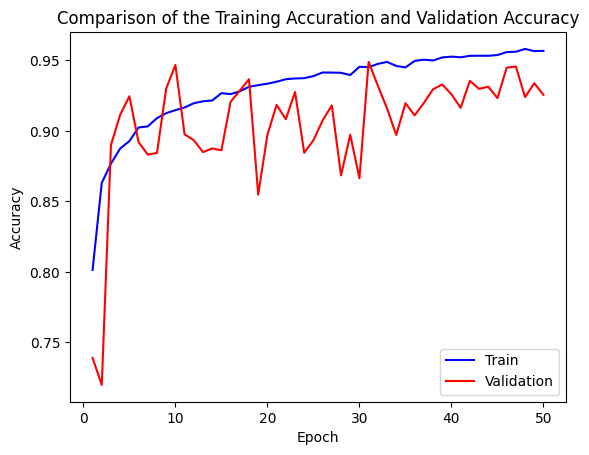

In [8]:
plt.plot(t, train_acc_list, 'b')
plt.plot(t, val_acc_list, 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title("Comparison of the Training Accuration and Validation Accuracy")
plt.show()

# Plot the training and validation losses 
Cross entropy loss was used

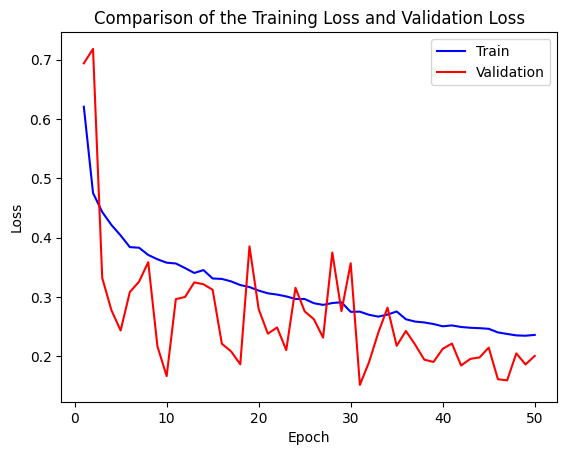

In [9]:
plt.plot(t, train_loss_list, 'b')
plt.plot(t, val_loss_list, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.title("Comparison of the Training Loss and Validation Loss")
plt.show()